# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

In [ ]:
import time
start_time = time.time()

import datetime
now = datetime.datetime.now()
print(f"Starting execution at: {now.hour}:{now.minute}")

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [3]:
events_sim = uproot.open('../shared/PhaseSpaceSimulation.root')
events_down = uproot.open('../shared/B2HHH_MagnetDown.root')
events_up = uproot.open('../shared/B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [ ]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
m_pipipi = []
m_KKK = []
m_Kpipi = []
mKKlow = []
mKKhigh = []
mKpi = []
mpipi = []
mpipilow = []
mpipihigh = []
probK = []
probPi = []

mpi = 140.
mK = 494.
mD = 1865.
mJp = 3097.
mp2S = 3686.
mB = 5280.
probK_all = 0.5
probK_high = 0.8
probK_sum = 2.1
probK_max = 0.7
probpi_all = 0.6
probpi_sum2 = 1.3
probpi_sum = 2.4
mass_cut = 50.
mass_cut_D = 20.

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
MAX_EVENTS = -1

# This outer loop is a technical loop of uproot over chunks of events
for tree in [events_down[b'DecayTree'],events_up['DecayTree']]:
  for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
    # As Python can handle calculations with arrays, we can calculate derived quantities here
    pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
    pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
    pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)
    e_pi1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mpi**2)
    e_pi2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mpi**2)
    e_pi3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mpi**2)
    e_K1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mK**2)
    e_K2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mK**2)
    e_K3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mK**2)
    p12sq = (data[b'H1_PX']+data[b'H2_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ'])**2
    p23sq = (data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H2_PZ']+data[b'H3_PZ'])**2
    p13sq = (data[b'H1_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H3_PZ'])**2

    m12KKsq = (e_K1+e_K2)**2 - p12sq
    m23KKsq = (e_K3+e_K2)**2 - p23sq
    m13KKsq = (e_K1+e_K3)**2 - p13sq
    m12pipisq = (e_pi1+e_pi2)**2 - p12sq
    m23pipisq = (e_pi3+e_pi2)**2 - p23sq
    m13pipisq = (e_pi1+e_pi3)**2 - p13sq
    m12Kpisq = (e_K1+e_pi2)**2 - p12sq
    m23Kpisq = (e_K3+e_pi2)**2 - p23sq
    m13Kpisq = (e_K1+e_pi3)**2 - p13sq
    m12piKsq = (e_pi1+e_K2)**2 - p12sq
    m23piKsq = (e_pi3+e_K2)**2 - p23sq
    m13piKsq = (e_pi1+e_K3)**2 - p13sq

    psq = (data[b'H1_PX']+data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ']+data[b'H3_PZ'])**2

    mKKKinv = np.sqrt((e_K1+e_K2+e_K3)**2 - psq)
    mpipipiinv = np.sqrt((e_pi1+e_pi2+e_pi3)**2 - psq)
    mKpipiinv = np.sqrt((e_K1+e_pi2+e_pi3)**2 - psq)
    mpiKpiinv = np.sqrt((e_pi1+e_K2+e_pi3)**2 - psq)
    mpipiKinv = np.sqrt((e_pi1+e_pi2+e_K3)**2 - psq)

    # This loop will go over individual events
    for i in range(0,len(data[b'H1_PZ'])):
        event_counter += 1
        if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
        if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
        # Decide here which events to analyse
        if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
        if data[b'H1_isMuon'][i] or data[b'H2_isMuon'][i] or data[b'H3_isMuon'][i]: continue
        # Fill arrays of events to be plotted and analysed further below
        # Adding values for all three hadrons to the same variable here
        pT.append(pT_H1[i])
        pT.append(pT_H2[i])
        pT.append(pT_H3[i])
        pX.append(data[b'H1_PX'][i])
        pX.append(data[b'H2_PX'][i])
        pX.append(data[b'H3_PX'][i])
        pY.append(data[b'H1_PY'][i])
        pY.append(data[b'H2_PY'][i])
        pY.append(data[b'H3_PY'][i])
        pZ.append(data[b'H1_PZ'][i])
        pZ.append(data[b'H2_PZ'][i])
        pZ.append(data[b'H3_PZ'][i])
        probK.append(data[b'H1_ProbK'][i])
        probPi.append(data[b'H1_ProbPi'][i])
        probK.append(data[b'H2_ProbK'][i])
        probPi.append(data[b'H2_ProbPi'][i])
        probK.append(data[b'H3_ProbK'][i])
        probPi.append(data[b'H3_ProbPi'][i])
        if ((data[b'H1_ProbK'][i] > probK_all) 
            and (data[b'H2_ProbK'][i] > probK_all) 
            and (data[b'H3_ProbK'][i] > probK_all)
            and (data[b'H1_ProbK'][i] + data[b'H2_ProbK'][i] + data[b'H3_ProbK'][i] > probK_sum)):
            if data[b'H1_Charge'][i] == data[b'H2_Charge'][i]:
                if m13KKsq[i] > m23KKsq[i]:
                    if np.abs(mKKKinv[i]-mB) < mass_cut: 
                        mKKlow.append(m23KKsq[i])
                        mKKhigh.append(m13KKsq[i])
                    if np.abs(m23KKsq[i]-mD) > mass_cut_D: 
                        m_KKK.append(mKKKinv[i])
                else:
                    if np.abs(mKKKinv[i]-mB) < mass_cut: 
                        mKKlow.append(m13KKsq[i])
                        mKKhigh.append(m23KKsq[i])
                    if np.abs(m13KKsq[i]-mD) > mass_cut_D: 
                        m_KKK.append(mKKKinv[i])
            elif data[b'H1_Charge'][i] == data[b'H3_Charge'][i]:
                if m12KKsq[i] > m23KKsq[i]:
                    if np.abs(mKKKinv[i]-mB) < mass_cut: 
                        mKKlow.append(m23KKsq[i])
                        mKKhigh.append(m12KKsq[i])
                    if np.abs(m23KKsq[i]-mD) > mass_cut_D: 
                        m_KKK.append(mKKKinv[i])
                else:
                    if np.abs(mKKKinv[i]-mB) < mass_cut: 
                        mKKlow.append(m12KKsq[i])
                        mKKhigh.append(m23KKsq[i])
                    if np.abs(m12KKsq[i]-mD) > mass_cut_D: 
                        m_KKK.append(mKKKinv[i])
            elif data[b'H2_Charge'][i] == data[b'H3_Charge'][i]:
                if m12KKsq[i] > m13KKsq[i]:
                    if np.abs(mKKKinv[i]-mB) < mass_cut: 
                        mKKlow.append(m13KKsq[i])
                        mKKhigh.append(m12KKsq[i])
                    if np.abs(m13KKsq[i]-mD) > mass_cut_D: 
                        m_KKK.append(mKKKinv[i])
                else:
                    if np.abs(mKKKinv[i]-mB) < mass_cut: 
                        mKKlow.append(m12KKsq[i])
                        mKKhigh.append(m13KKsq[i])
                    if np.abs(m12KKsq[i]-mD) > mass_cut_D: 
                        m_KKK.append(mKKKinv[i])

        elif ((data[b'H1_ProbPi'][i] > probpi_all) 
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H1_ProbK'][i] < probK_max)
              and (data[b'H2_ProbK'][i] < probK_max)
              and (data[b'H3_ProbK'][i] < probK_max)
              and (data[b'H1_ProbPi'][i] + data[b'H2_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum)):
            if data[b'H1_Charge'][i] == data[b'H2_Charge'][i]:
                if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    if m13pipisq[i] > m23pipisq[i]:
                        mpipilow.append(m23pipisq[i])
                        mpipihigh.append(m13pipisq[i])
                    else:
                        mpipilow.append(m13pipisq[i])
                        mpipihigh.append(m23pipisq[i])
                if (np.abs(m13pipisq[i]-mD) > mass_cut_D) and (np.abs(m23pipisq[i]-mD) > mass_cut_D): 
                    m_pipipi.append(mpipipiinv[i])
            elif data[b'H1_Charge'][i] == data[b'H3_Charge'][i]:
                if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    if m12pipisq[i] > m23pipisq[i]:
                        mpipilow.append(m23pipisq[i])
                        mpipihigh.append(m12pipisq[i])
                    else:
                        mpipilow.append(m12pipisq[i])
                        mpipihigh.append(m23pipisq[i])
                if (np.abs(m12pipisq[i]-mD) > mass_cut_D) and (np.abs(m23pipisq[i]-mD) > mass_cut_D): 
                    m_pipipi.append(mpipipiinv[i])
            elif data[b'H2_Charge'][i] == data[b'H3_Charge'][i]:
                if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    if m12pipisq[i] > m13pipisq[i]:
                        mpipilow.append(m13pipisq[i])
                        mpipihigh.append(m12pipisq[i])
                    else:
                        mpipilow.append(m12pipisq[i])
                        mpipihigh.append(m13pipisq[i])
                if (np.abs(m13pipisq[i]-mD) > mass_cut_D) and (np.abs(m12pipisq[i]-mD) > mass_cut_D): 
                    m_pipipi.append(mpipipiinv[i])
       
        elif ((data[b'H1_ProbK'][i] > data[b'H2_ProbK'][i]) and (data[b'H1_ProbK'][i] > data[b'H3_ProbK'][i])
              and (data[b'H2_Charge'][i] != data[b'H3_Charge'][i])
              and (data[b'H1_ProbK'][i] > probK_high)
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H2_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum2)):
            if (data[b'H1_Charge'][i] != data[b'H2_Charge'][i]):
                if np.abs(mKpipiinv[i]-mB) < mass_cut: 
                    mKpi.append(m12Kpisq[i])
                    mpipi.append(m23pipisq[i])
                if np.abs(m12Kpisq[i]-mD) > mass_cut_D: 
                    m_Kpipi.append(mKpipiinv[i])
            else:
                if np.abs(mKpipiinv[i]-mB) < mass_cut: 
                    mKpi.append(m13Kpisq[i])
                    mpipi.append(m23pipisq[i])
                if np.abs(m13Kpisq[i]-mD) > mass_cut_D: 
                    m_Kpipi.append(mKpipiinv[i])

        elif ((data[b'H2_ProbK'][i] > data[b'H1_ProbK'][i]) and (data[b'H2_ProbK'][i] > data[b'H3_ProbK'][i])
              and (data[b'H1_Charge'][i] != data[b'H3_Charge'][i])
              and (data[b'H2_ProbK'][i] > probK_high)
              and (data[b'H1_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H1_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum2)):
            if (data[b'H2_Charge'][i] != data[b'H1_Charge'][i]):
                if np.abs(mpiKpiinv[i]-mB) < mass_cut: 
                    mKpi.append(m12piKsq[i])
                    mpipi.append(m13pipisq[i])
                if np.abs(m12piKsq[i]-mD) > mass_cut_D: 
                    m_Kpipi.append(mpiKpiinv[i])
            else:
                if np.abs(mpiKpiinv[i]-mB) < mass_cut: 
                    mKpi.append(m23Kpisq[i])
                    mpipi.append(m13pipisq[i])
                if np.abs(m23Kpisq[i]-mD) > mass_cut_D: 
                    m_Kpipi.append(mpiKpiinv[i])

        elif ((data[b'H3_ProbK'][i] > data[b'H2_ProbK'][i]) and (data[b'H3_ProbK'][i] > data[b'H1_ProbK'][i])
              and (data[b'H1_Charge'][i] != data[b'H2_Charge'][i])
              and (data[b'H3_ProbK'][i] > probK_high)
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H1_ProbPi'][i] > probpi_all)
              and (data[b'H2_ProbPi'][i] + data[b'H1_ProbPi'][i] > probpi_sum2)):
            if (data[b'H3_Charge'][i] != data[b'H1_Charge'][i]):
                if np.abs(mpipiKinv[i]-mB) < mass_cut: 
                    mKpi.append(m13piKsq[i])
                    mpipi.append(m12pipisq[i])
                if np.abs(m13piKsq[i]-mD) > mass_cut_D: 
                    m_Kpipi.append(mpipiKinv[i])
            else:
                if np.abs(mpipiKinv[i]-mB) < mass_cut: 
                    mKpi.append(m23piKsq[i])
                    mpipi.append(m12pipisq[i])
                if np.abs(m23piKsq[i]-mD) > mass_cut_D: 
                    m_Kpipi.append(mpipiKinv[i])
 
print('Read {:d} events'.format(event_counter))

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 100000 events
Read 200000 events
Read 300000 events
Read 400000 events
Read 500000 events
Read 600000 events
Read 700000 events
Read 800000 events
Read 900000 events
Read 1000000 events
Read 1100000 events
Read 1200000 events
Read 1300000 events
Read 1400000 events
Read 1500000 events
Read 1600000 events
Read 1700000 events
Read 1800000 events
Read 1900000 events
Read 2000000 events
Read 2100000 events
Read 2200000 events
Read 2300000 events
Read 2400000 events
Read 2500000 events
Read 2600000 events
Read 2700000 events
Read 2800000 events
Read 2900000 events
Read 3000000 events
Read 3100000 events
Read 3200000 events
Read 330000

### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram
Plotting 2D histogram


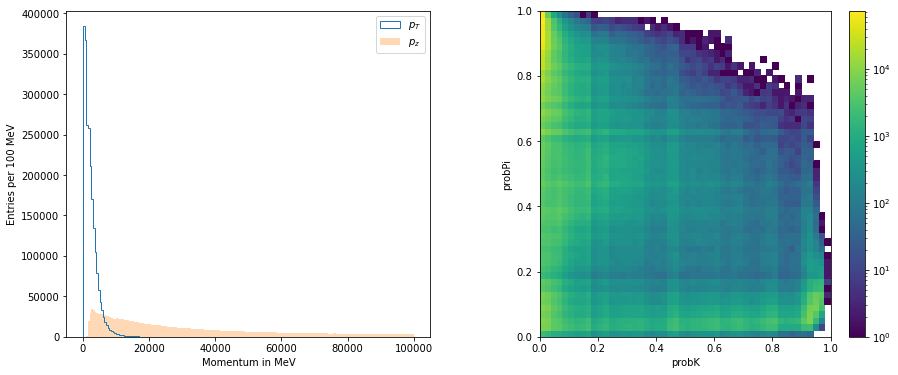

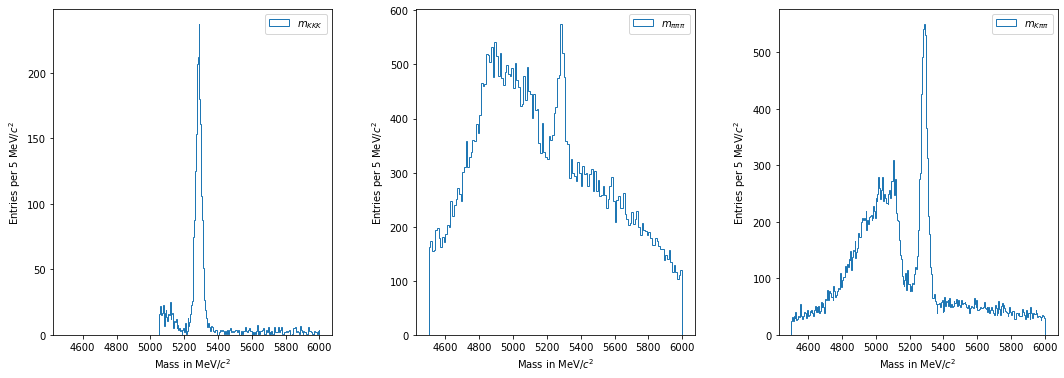

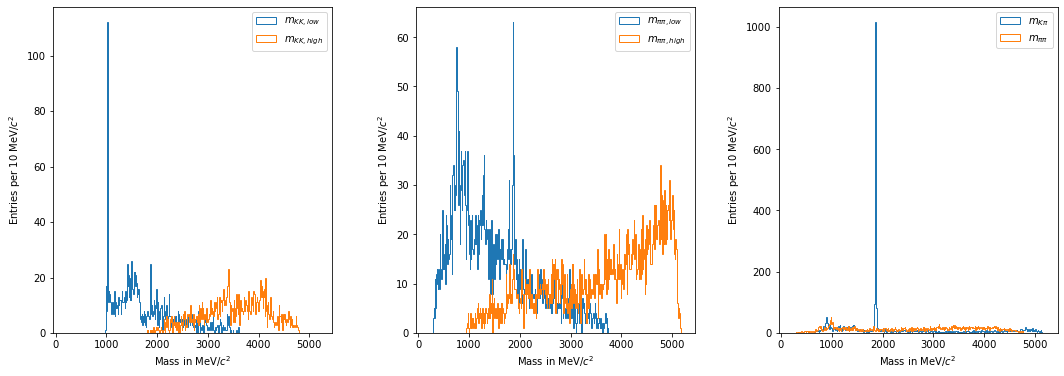

In [5]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
#h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
h2d = ax[1].hist2d(probK, probPi, bins = [50,50], range = [[0,1],[0,1]],norm=colors.LogNorm())
ax[1].set_xlabel('probK')
ax[1].set_ylabel('probPi')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('probKpi.pdf')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
values_mKKK,bins_mKKK,patches_mKKK = ax[0].hist(m_KKK, bins = 300, range = [4500, 6000],histtype='step',label='$m_{KKK}$')
values_mpipipi,bins_mpipipi,patches_mpipipi = ax[1].hist(m_pipipi, bins = 150, range = [4500, 6000],histtype='step',label='$m_{\pi\pi\pi}$')
values_mKpipi,bins_mKpipi,patches_mKpipi = ax[2].hist(m_Kpipi, bins = 300, range = [4500, 6000],histtype='step',label='$m_{K\pi\pi}$')
ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries per 5 MeV/$c^2$')
ax[0].legend()
plt.savefig('mKKK.pdf')
ax[1].set_xlabel('Mass in MeV/$c^2$')
ax[1].set_ylabel('Entries per 5 MeV/$c^2$')
ax[1].legend()
plt.savefig('mpipipi.pdf')
ax[2].set_xlabel('Mass in MeV/$c^2$')
ax[2].set_ylabel('Entries per 5 MeV/$c^2$')
ax[2].legend()
plt.savefig('mKpipi.pdf')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
ax[0].hist(np.sqrt(mKKlow), bins = 500, range = [200, 5200],histtype='step',label='$m_{KK,low}$')
ax[0].hist(np.sqrt(mKKhigh), bins = 500, range = [200, 5200],histtype='step',label='$m_{KK,high}$')

ax[1].hist(np.sqrt(mpipilow), bins = 500, range = [200, 5200],histtype='step',label='$m_{\pi\pi,low}$')
ax[1].hist(np.sqrt(mpipihigh), bins = 500, range = [200, 5200],histtype='step',label='$m_{\pi\pi,high}$')

ax[2].hist(np.sqrt(mKpi), bins = 500, range = [200, 5200],histtype='step',label='$m_{K\pi}$')
ax[2].hist(np.sqrt(mpipi), bins = 500, range = [200, 5200],histtype='step',label='$m_{\pi\pi}$')

ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries per 10 MeV/$c^2$')
ax[0].legend()
plt.savefig('mKK.pdf')
ax[1].set_xlabel('Mass in MeV/$c^2$')
ax[1].set_ylabel('Entries per 10 MeV/$c^2$')
ax[1].legend()
plt.savefig('mpipi.pdf')
ax[2].set_xlabel('Mass in MeV/$c^2$')
ax[2].set_ylabel('Entries per 10 MeV/$c^2$')
ax[2].legend()
plt.savefig('mKpi_pipi.pdf')



### Analyse data
The cell below fits a function to the histogram data for transverse momentum. While the different plotting style requires some manipulation of the data points, no new histogram is created from the input data but rather the histogram produced in the previous cell is used.

The following bit of code makes a crude evaluation of the pipipi significance to aid the optimisation of the PID selection. Several outputs, obtained on a smaller sample without muon veto, are:

Kmax 0.3 piAll 0.5 piSum 2.0 S 308.0 B 635.0 S/B 0.48503937007874015 sig 10.029859978997877

Kmax 0.5 piAll 0.5 piSum 2.0 S 330.5 B 707.5 S/B 0.46713780918727915 sig 10.258238382910418

Kmax 0.3 piAll 0.6 piSum 2.4 S 245.5 B 306.5 S/B 0.800978792822186 sig 10.44917391506364

Kmax 0.4 piAll 0.6 piSum 2.4 S 256.0 B 317.0 S/B 0.807570977917981 sig 10.694553424495535

Kmax 0.5 piAll 0.6 piSum 2.4 S 260.0 B 321.0 S/B 0.8099688473520249 sig 10.78661757738529

Kmax 0.6 piAll 0.6 piSum 2.4 S 266.5 B 323.5 S/B 0.8238021638330757 sig 10.971631369821639

Kmax 0.7 piAll 0.6 piSum 2.4 S 272.0 B 325.0 S/B 0.8369230769230769 sig 11.13221892335279 <===

Kmax 0.8 piAll 0.6 piSum 2.4 S 272.0 B 326.0 S/B 0.8343558282208589 sig 11.122907153489617

Kmax 0.9 piAll 0.6 piSum 2.4 S 271.0 B 327.0 S/B 0.8287461773700305 sig 11.08201411248414

Kmax 0.7 piAll 0.5 piSum 2.3 S 328.5 B 489.5 S/B 0.6710929519918284 sig 11.485733150942954

Kmax 0.7 piAll 0.6 piSum 2.3 S 288.5 B 395.5 S/B 0.729456384323641 sig 11.03107320360951

Kmax 0.7 piAll 0.5 piSum 2.4 S 284.5 B 367.5 S/B 0.7741496598639456 sig 11.141879901078694

Kmax 0.7 piAll 0.5 piSum 2.5 S 211.5 B 224.5 S/B 0.9420935412026726 sig 10.129012966213676

Kmax 0.7 piAll 0.6 piSum 2.4 S 272.0 B 325.0 S/B 0.8369230769230769 sig 11.13221892335279 <===

Kmax 0.7 piAll 0.7 piSum 2.4 S 212.0 B 233.0 S/B 0.9098712446351931 sig 10.049763818567516

Kmax 0.5 piAll 0.6 piSum 2.5 S 208.0 B 218.0 S/B 0.9541284403669725 sig 10.077632928719392

Kmax 0.5 piAll 0.6 piSum 2.6 S 152.5 B 122.5 S/B 1.2448979591836735 sig 9.19609600962179

Kmax 0.7 piAll 0.6 piSum 2.4 S 2276.0 B 2768.0 S/B 0.8222543352601156 sig 32.04680359935707

In [6]:
snb = values_mpipipi[78]
b=(values_mpipipi[69]+values_mpipipi[87])/2
s = snb-b
significance = s/np.sqrt(snb)

print('Kmax',probK_max,'piAll',probpi_all,'piSum',probpi_sum,'S',s,'B',b,'S/B',s/b,'sig',significance)

Kmax 0.7 piAll 0.6 piSum 2.4 S 267.5 B 306.5 S/B 0.8727569331158238 sig 11.1652342763595


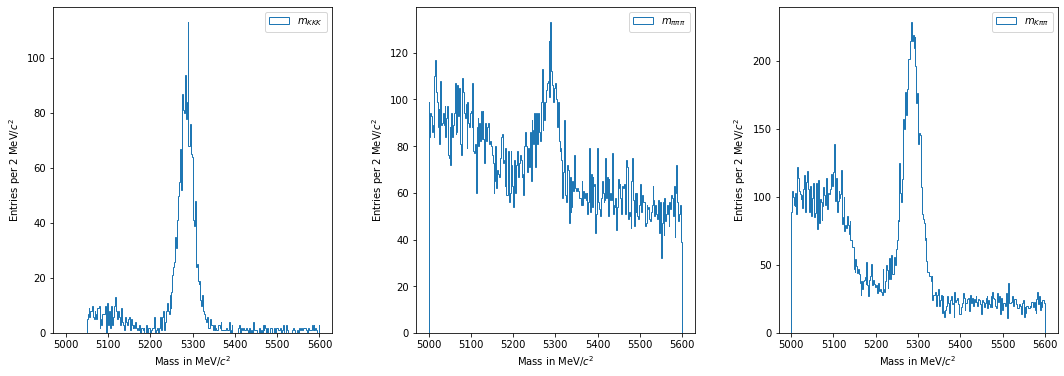

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
values_mKKK,bins_mKKK,patches_mKKK = ax[0].hist(m_KKK, bins = 300, range = [5000, 5600],histtype='step',label='$m_{KKK}$')
values_mpipipi,bins_mpipipi,patches_mpipipi = ax[1].hist(m_pipipi, bins = 300, range = [5000, 5600],histtype='step',label='$m_{\pi\pi\pi}$')
values_mKpipi,bins_mKpipi,patches_mKpipi = ax[2].hist(m_Kpipi, bins = 300, range = [5000, 5600],histtype='step',label='$m_{K\pi\pi}$')
ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries per 2 MeV/$c^2$')
ax[0].legend()
plt.savefig('mKKK_narrow.pdf')
ax[1].set_xlabel('Mass in MeV/$c^2$')
ax[1].set_ylabel('Entries per 2 MeV/$c^2$')
ax[1].legend()
plt.savefig('mpipipi_narrow.pdf')
ax[2].set_xlabel('Mass in MeV/$c^2$')
ax[2].set_ylabel('Entries per 2 MeV/$c^2$')
ax[2].legend()
plt.savefig('mKpipi_narrow.pdf')

Fit results with chi2/ndf 129.48192704008895 / 188
Par 1: 453.798284 +/- 471.806499
Par 2: 18.710932 +/- 12.537934
Par 3: 3533.300964 +/- 60.581154
Par 4: 5284.452717 +/- 0.282839
Par 5: 16.830521 +/- 0.299461
Par 6: 4.040424 +/- 1.981372
Par 7: 422.506447 +/- 287.064885
Fit results with chi2/ndf 214.41208946884376 / 200
Par 1: 1228.777212 +/- 537.739913
Par 2: 34.781547 +/- 10.903292
Par 3: 2344.756128 +/- 192.325219
Par 4: 5284.508220 +/- 1.399643
Par 5: 21.033021 +/- 1.603885
Par 6: 80.248168 +/- 4.546666
Par 7: 1350.829428 +/- 271.633638
Fit results with chi2/ndf 248.66998348708788 / 200
Par 1: 5025.688708 +/- 387.321299
Par 2: 28.662579 +/- 1.661289
Par 3: 8810.321910 +/- 143.795670
Par 4: 5285.057322 +/- 0.284027
Par 5: 18.868187 +/- 0.307838
Par 6: 53.067499 +/- 4.630462
Par 7: 487.912826 +/- 62.317414


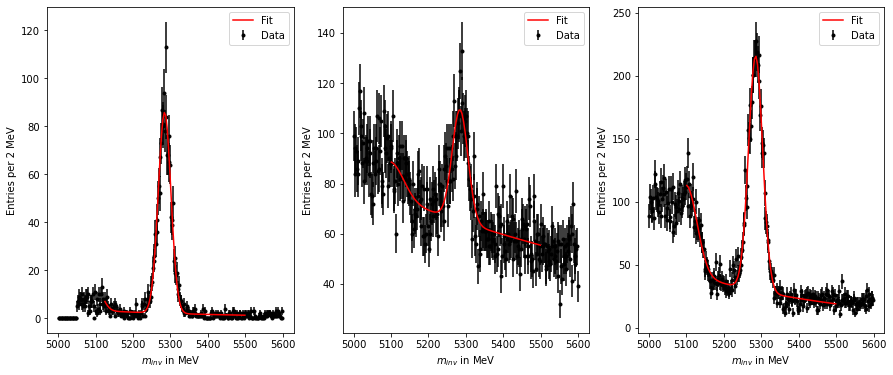

In [10]:
# decaying exponential function
def exponential(x, norm, decay):
    return np.array( norm * np.exp(-(x-5000)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# Gaussian function
def gauss(x, norm, mu, sigma):
    return np.array( norm / np.sqrt(2*np.pi) / sigma * np.exp( -(x-mu)**2 / 2 / sigma**2 ) )


# fit function combining two individual functions
def fit_function(x, norm4, sigma4, normG, muG, sigmaG, normE, decay):
    return np.array( gauss(x, norm4, 5100, sigma4) + gauss(x, normG, muG, sigmaG) + exponential(x, normE, decay) )

def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values 5000 and 10^-4
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0) # fit
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6])
    a.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

    # plot decoration
    a.legend()
    a.set_xlabel('$m_{inv}$ in MeV')
    a.set_ylabel('Entries per 2 MeV')
    plt.savefig(fname)

coeff_KKK_fit,cov_KKK_fit, bin_centres_KKK, bin_centres_red_KKK, chi2_KKK, ndf_KKK = fit_data( bins_mKKK, values_mKKK, 5125, 5500, [2000,30,30000,5285,20,40,500] )
coeff_pipipi_fit,cov_pipipi_fit, bin_centres_pipipi, bin_centres_red_pipipi, chi2_pipipi, ndf_pipipi = fit_data( bins_mpipipi, values_mpipipi, 5100, 5500, [8000,30,10000,5285,20,1000,500] )
coeff_Kpipi_fit,cov_Kpipi_fit, bin_centres_Kpipi, bin_centres_red_Kpipi, chi2_Kpipi, ndf_Kpipi = fit_data( bins_mKpipi, values_mKpipi, 5100, 5500, [15000,30,60000,5285,20,400,500] )

print_results(coeff_KKK_fit,cov_KKK_fit, chi2_KKK, ndf_KKK)
print_results(coeff_pipipi_fit,cov_pipipi_fit, chi2_pipipi, ndf_pipipi)
print_results(coeff_Kpipi_fit,cov_Kpipi_fit, chi2_Kpipi, ndf_Kpipi)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

plot_results(ax[0],bin_centres_KKK,bin_centres_red_KKK,values_mKKK,coeff_KKK_fit,'mfit_KKK.pdf')
plot_results(ax[1],bin_centres_pipipi,bin_centres_red_pipipi,values_mpipipi,coeff_pipipi_fit,'mfit_pipipi.pdf')
plot_results(ax[2],bin_centres_Kpipi,bin_centres_red_Kpipi,values_mKpipi,coeff_Kpipi_fit,'mfit_Kpipi.pdf')


In [ ]:
end_time = time.time()
elapsed = end_time - start_time
minutes = int(elapsed // 60)
seconds = int(elapsed % 60)
print(f"Total execution time: {minutes} min {seconds} sec")